In [2]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import cmocean as ocean
import xarray as xr
import pandas as pd
import os.path as op
from xgcm import Grid
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
from scipy.signal import medfilt, medfilt2d
from scipy.ndimage.filters import gaussian_filter as gaus
import scipy.stats as stats
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
comdir = '/swot/SUM02/takaya/SOCCOM/SIO'
limdir = '/swot/SUM03/Argo_BGC_backscatter_SO_merged'

In [4]:
comdir = '/swot/SUM02/takaya/SOCCOM/SIO'
pf = pd.read_csv(op.join(comdir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(comdir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])

In [5]:
comC = pd.read_csv(op.join(comdir,'SOCCOM_Cs.csv'),
                  infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
comR = pd.read_csv(op.join(comdir,'SOCCOM_rates.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
# limC = pd.read_csv(op.join(limdir,'../Argo_Analysis/SOCLIM_Cs.csv'),
#                    infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
# limR = pd.read_csv(op.join(limdir,'../Argo_Analysis/SOCLIM_rates.csv'),
#                    infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
limC = pd.read_csv(op.join(comdir,'../../SOCLIM/SOCLIM-sanspEu_Cs.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])
limR = pd.read_csv(op.join(comdir,'../../SOCLIM/SOCLIM-sanspEu_rates.csv'),
                   infer_datetime_format=True, keep_date_col=True, parse_dates=['time']).drop(columns=['Unnamed: 0'])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


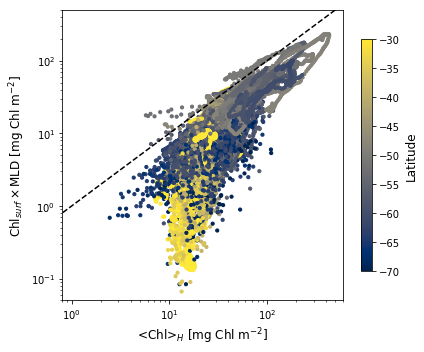

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax.plot(np.arange(1e3), np.arange(1e3), 'k--')
im = ax.scatter(comC.ChlH_rolled, comC.ChlsML_rolled, c=comC.Lat, vmin=-70, vmax=-30, s=10, cmap='cividis', rasterized=True)
ax.scatter(limC.ChlH_rolled, limC.ChlsML_rolled, c=limC.Lat, vmin=-70, vmax=-30, s=10, cmap='cividis', rasterized=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([.8,6e2])
ax.set_ylim([.05,5e2])
ax.set_xlabel(r"<Chl>$_{H}$ [mg Chl m$^{-2}$]", fontsize=12)
ax.set_ylabel(r"Chl$_{surf}\times$MLD [mg Chl m$^{-2}$]", fontsize=12)
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Latitude', fontsize=12)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.data is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.data is deprecated and will be removed in a future version
  if sys.path[0] == '':
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


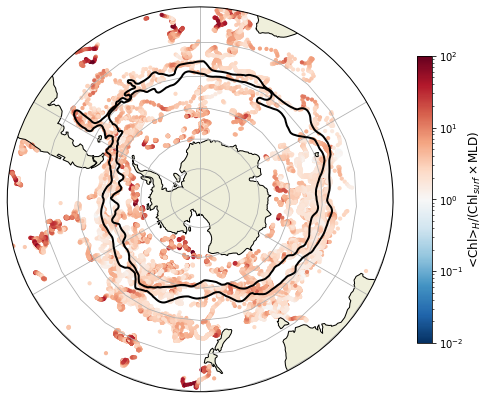

In [9]:
fig = plt.figure(figsize=(7,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

im = ax.scatter(comC.Lon, comC.Lat, c=comC.ChlH_rolled/comC.ChlsML_rolled, vmin=0.01, vmax=100, s=10, 
                cmap='RdBu_r', norm=clr.LogNorm(), transform=ccrs.PlateCarree())
ax.scatter(limC.Lon, limC.Lat, c=limC.ChlH_rolled/limC.ChlsML_rolled, vmin=0.01, vmax=100, s=10, 
           cmap='RdBu_r', norm=clr.LogNorm(), transform=ccrs.PlateCarree())

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label(r"<Chl>$_{H}$/(Chl$_{surf}\times$MLD)", fontsize=12)

In [12]:
subcomC0 = comC.where(comC.time>np.datetime64('2014-06-01')
                     ).where(comC.time<np.datetime64('2015-03-31')).dropna(subset=['time'])
subcomC1 = comC.where(comC.time>np.datetime64('2015-06-01')
                     ).where(comC.time<np.datetime64('2016-03-31')).dropna(subset=['time'])
subcomC2 = comC.where(comC.time>np.datetime64('2016-06-01')
                     ).where(comC.time<np.datetime64('2017-03-31')).dropna(subset=['time'])
subcomC3 = comC.where(comC.time>np.datetime64('2017-06-01')
                     ).where(comC.time<np.datetime64('2018-03-31')).dropna(subset=['time'])
subcomC4 = comC.where(comC.time>np.datetime64('2018-06-01')
                     ).where(comC.time<np.datetime64('2019-03-31')).dropna(subset=['time'])

subcomR0 = comR.where(comR.time>np.datetime64('2014-06-01')
                     ).where(comR.time<np.datetime64('2015-03-31')).dropna(subset=['time'])
subcomR1 = comR.where(comR.time>np.datetime64('2015-06-01')
                     ).where(comR.time<np.datetime64('2016-03-31')).dropna(subset=['time'])
subcomR2 = comR.where(comR.time>np.datetime64('2016-06-01')
                     ).where(comR.time<np.datetime64('2017-03-31')).dropna(subset=['time'])
subcomR3 = comR.where(comR.time>np.datetime64('2017-06-01')
                     ).where(comR.time<np.datetime64('2018-03-31')).dropna(subset=['time'])
subcomR4 = comR.where(comR.time>np.datetime64('2018-06-01')
                     ).where(comR.time<np.datetime64('2019-03-31')).dropna(subset=['time'])

In [13]:
sublimC2 = limC.where(limC.time>np.datetime64('2016-06-01')
                     ).where(limC.time<np.datetime64('2017-03-31')).dropna(subset=['time'])
sublimC3 = limC.where(limC.time>np.datetime64('2017-06-01')
                     ).where(limC.time<np.datetime64('2018-03-31')).dropna(subset=['time'])
sublimC4 = limC.where(limC.time>np.datetime64('2018-06-01')
                     ).where(limC.time<np.datetime64('2019-03-31')).dropna(subset=['time'])

sublimR2 = limR.where(limR.time>np.datetime64('2016-06-01')
                     ).where(limR.time<np.datetime64('2017-03-31')).dropna(subset=['time'])
sublimR3 = limR.where(limR.time>np.datetime64('2017-06-01')
                     ).where(limR.time<np.datetime64('2018-03-31')).dropna(subset=['time'])
sublimR4 = limR.where(limR.time>np.datetime64('2018-06-01')
                     ).where(limR.time<np.datetime64('2019-03-31')).dropna(subset=['time'])

In [19]:
groupLC2 = sublimC2.groupby('floatID')
groupLC3 = sublimC3.groupby('floatID')
groupLC4 = sublimC4.groupby('floatID')
i,j = (0,0)
for name,group in groupLC2:
#     print(name)
    grp = pd.DataFrame(group)
#     plt.plot(grp.time)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-10-01') and grp.time.values[-1] > np.datetime64('2016-12-31'):
            Apl2 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-10-01') and grp.time.values[-1] > np.datetime64('2016-12-31'):
            Apl2 = pd.concat([Apl2,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupLC2:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2016-07-31') and grp.time.values[-1] > np.datetime64('2016-10-01'):
            Onl2 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-07-31') and grp.time.values[-1] > np.datetime64('2016-10-01'):
            Onl2 = pd.concat([Onl2,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
i,j = (0,0)
for name,group in groupLC3:
#     print(name)
    grp = pd.DataFrame(group)
#     plt.plot(grp.time)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-10-01') and grp.time.values[-1] > np.datetime64('2017-12-31'):
            Apl3 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-10-01') and grp.time.values[-1] > np.datetime64('2017-12-31'):
            Apl3 = pd.concat([Apl3,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                             'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupLC3:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2017-07-31') and grp.time.values[-1] > np.datetime64('2017-10-01'):
            Onl3 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-07-31') and grp.time.values[-1] > np.datetime64('2017-10-01'):
            Onl3 = pd.concat([Onl3,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                             'pEu','CH'])], 
                            ignore_index=True)
i,j = (0,0)
for name,group in groupLC4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-10-01') and grp.time.values[-1] > np.datetime64('2018-12-31'):
            Apl4 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-10-01') and grp.time.values[-1] > np.datetime64('2018-12-31'):
            Apl4 = pd.concat([Apl4,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupLC4:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2018-07-31') and grp.time.values[-1] > np.datetime64('2018-10-01'):
            Onl4 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-07-31') and grp.time.values[-1] > np.datetime64('2018-10-01'):
            Onl4 = pd.concat([Onl4,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

i = 0
for name,group in groupLC2:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-07-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            MLl2 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-07-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            MLl2 = pd.concat([MLl2,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupLC3:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-07-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            MLl3 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-07-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            MLl3 = pd.concat([MLl3,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                              'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupLC4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-07-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            MLl4 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-07-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            MLl4 = pd.concat([MLl4,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: All-NaN axis encountered
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: All-NaN axis encountered


In [20]:
groupLR2 = sublimR2.groupby('floatID')
groupLR3 = sublimR3.groupby('floatID')
groupLR4 = sublimR4.groupby('floatID')
i = 0
for name,group in groupLR2:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-08-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            Cll2 = grp[grp.rPH==np.nanmax(grp.rPH)]
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-08-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            Cll2 = pd.concat([Cll2,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

i = 0
for name,group in groupLR3:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-08-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            Cll3 = grp[grp.rPH==np.nanmax(grp.rPH)]
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-08-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            Cll3 = pd.concat([Cll3,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

i = 0
for name,group in groupLR4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-08-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            Cll4 = grp[grp.rPH==np.nanmax(grp.rPH)]
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-08-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            Cll4 = pd.concat([Cll4,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered


In [22]:
groupCC0 = subcomC0.groupby('floatID')
groupCC1 = subcomC1.groupby('floatID')
groupCC2 = subcomC2.groupby('floatID')
groupCC3 = subcomC3.groupby('floatID')
groupCC4 = subcomC4.groupby('floatID')
i,j = (0,0)
for name,group in groupCC0:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2014-10-01') and grp.time.values[-1] > np.datetime64('2014-12-31'):
            Apc0 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2014-10-01') and grp.time.values[-1] > np.datetime64('2014-12-31'):
            Apc0 = pd.concat([Apc0,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupCC0:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2014-07-31') and grp.time.values[-1] > np.datetime64('2014-10-01'):
            Onc0 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2014-07-31') and grp.time.values[-1] > np.datetime64('2014-10-01'):
            Onc0 = pd.concat([Onc0,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

i,j = (0,0)
for name,group in groupCC1:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2015-10-01') and grp.time.values[-1] > np.datetime64('2015-12-31'):
            Apc1 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2015-10-01') and grp.time.values[-1] > np.datetime64('2015-12-31'):
            Apc1 = pd.concat([Apc1,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupCC1:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2015-07-31') and grp.time.values[-1] > np.datetime64('2015-10-01'):
            Onc1 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2015-07-31') and grp.time.values[-1] > np.datetime64('2015-10-01'):
            Onc1 = pd.concat([Onc1,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

i,j = (0,0)
for name,group in groupCC2:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-10-01') and grp.time.values[-1] > np.datetime64('2016-12-31'):
            Apc2 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-10-01') and grp.time.values[-1] > np.datetime64('2016-12-31'):
            Apc2 = pd.concat([Apc2,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupCC2:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2016-07-31') and grp.time.values[-1] > np.datetime64('2016-10-01'):
            Onc2 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-07-31') and grp.time.values[-1] > np.datetime64('2016-10-01'):
            Onc2 = pd.concat([Onc2,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

i,j = (0,0)
for name,group in groupCC3:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-10-01') and grp.time.values[-1] > np.datetime64('2017-12-31'):
            Apc3 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-10-01') and grp.time.values[-1] > np.datetime64('2017-12-31'):
            Apc3 = pd.concat([Apc3,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupCC3:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2017-07-31') and grp.time.values[-1] > np.datetime64('2017-10-01'):
            Onc3 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-07-31') and grp.time.values[-1] > np.datetime64('2017-10-01'):
            Onc3 = pd.concat([Onc3,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

i,j = (0,0)
for name,group in groupCC4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-10-01') and grp.time.values[-1] > np.datetime64('2018-12-31'):
            Apc4 = grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-10-01') and grp.time.values[-1] > np.datetime64('2018-12-31'):
            Apc4 = pd.concat([Apc4,grp[grp.CH_rolled==np.nanmax(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)
for name,group in groupCC4:
    grp = pd.DataFrame(group)
    if j == 0:
        if grp.time.values[0] < np.datetime64('2018-07-31') and grp.time.values[-1] > np.datetime64('2018-10-01'):
            Onc4 = grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML','pEu','CH'])
            j += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-07-31') and grp.time.values[-1] > np.datetime64('2018-10-01'):
            Onc4 = pd.concat([Onc4,grp[grp.CH_rolled==np.nanmin(grp.CH_rolled)].drop(columns=['pML',
                                                                                            'pEu','CH'])], 
                            ignore_index=True)

##################
i = 0
for name,group in groupCC0:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2014-07-01') and grp.time.values[-1] > np.datetime64('2014-11-30'):
            MLc0 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2014-07-01') and grp.time.values[-1] > np.datetime64('2014-11-30'):
            MLc0 = pd.concat([MLc0,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupCC1:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2015-07-01') and grp.time.values[-1] > np.datetime64('2015-11-30'):
            MLc1 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2015-07-01') and grp.time.values[-1] > np.datetime64('2015-11-30'):
            MLc1 = pd.concat([MLc1,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupCC2:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-07-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            MLc2 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-07-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            MLc2 = pd.concat([MLc2,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupCC3:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-07-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            MLc3 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-07-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            MLc3 = pd.concat([MLc3,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                              'pEu','CH'])], 
                             ignore_index=True)
i = 0
for name,group in groupCC4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-07-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            MLc4 = grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML','pEu','CH'])
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-07-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            MLc4 = pd.concat([MLc4,grp[grp.pML_rolled==np.nanmax(grp.pML_rolled)].drop(columns=['pML',
                                                                                               'pEu','CH'])], 
                             ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: All-NaN axis encountered


In [23]:
groupCR0 = subcomR0.groupby('floatID')
groupCR1 = subcomR1.groupby('floatID')
groupCR2 = subcomR2.groupby('floatID')
groupCR3 = subcomR3.groupby('floatID')
groupCR4 = subcomR4.groupby('floatID')
i = 0
for name,group in groupCR0:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2014-08-01') and grp.time.values[-1] > np.datetime64('2014-11-30'):
            Clc0 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2014-08-01') and grp.time.values[-1] > np.datetime64('2014-11-30'):
            Clc0 = pd.concat([Clc0,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

i = 0
for name,group in groupCR1:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2015-08-01') and grp.time.values[-1] > np.datetime64('2015-11-30'):
            Clc1 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2015-08-01') and grp.time.values[-1] > np.datetime64('2015-11-30'):
            Clc1 = pd.concat([Clc1,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)
        
i = 0
for name,group in groupCR2:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2016-08-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            Clc2 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2016-08-01') and grp.time.values[-1] > np.datetime64('2016-11-30'):
            Clc2 = pd.concat([Clc2,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

i = 0
for name,group in groupCR3:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2017-08-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            Clc3 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2017-08-01') and grp.time.values[-1] > np.datetime64('2017-11-30'):
            Clc3 = pd.concat([Clc3,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

i = 0
for name,group in groupCR4:
#     print(name)
    grp = pd.DataFrame(group)
    if i == 0:
        if grp.time.values[0] < np.datetime64('2018-08-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            Clc4 = grp[grp.rPH==np.nanmax(grp.rPH)]
        i += 1
    else:
        if grp.time.values[0] < np.datetime64('2018-08-01') and grp.time.values[-1] > np.datetime64('2018-11-30'):
            Clc4 = pd.concat([Clc4,grp[grp.rPH==np.nanmax(grp.rPH)]], 
                            ignore_index=True)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:188: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:192: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:193: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:196: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:197: FutureWarning: Series.data is depreca

Text(0.5, 1.0, '$t_{ML}$')

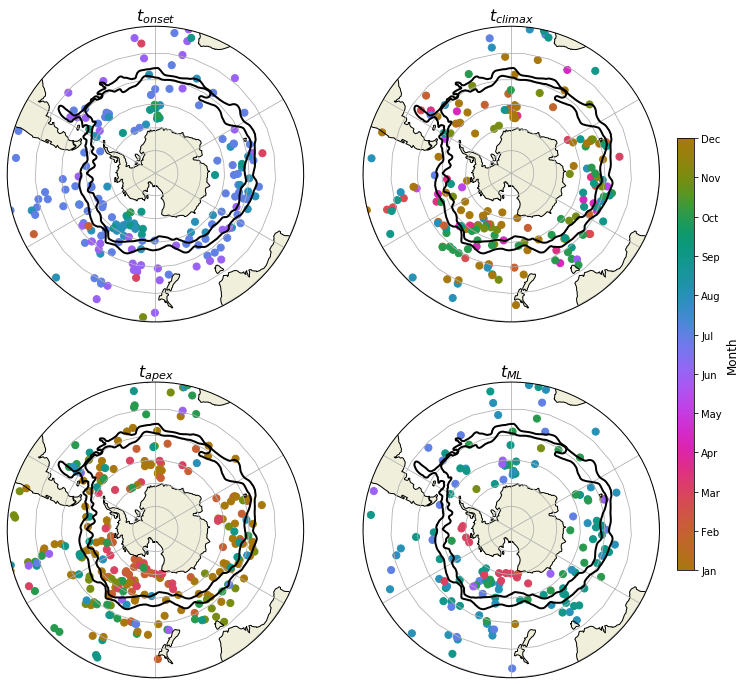

In [24]:
color = ocean.cm.phase
vm = 1
vM = 12
size=50
dm = 12

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(2,2,2,projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(2,2,3,projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(2,2,4,projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND)
ax4.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax3.set_boundary(circle, transform=ax3.transAxes)
ax4.set_boundary(circle, transform=ax4.transAxes)
month = pd.DatetimeIndex(Onc3.time).month.values
im1 = ax1.scatter(Onc3.Lon, Onc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc0.time).month.values
ax1.scatter(Onc0.Lon, Onc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc1.time).month.values
ax1.scatter(Onc1.Lon, Onc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc2.time).month.values
ax1.scatter(Onc2.Lon, Onc2.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onc4.time).month.values
ax1.scatter(Onc4.Lon, Onc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onl3.time).month.values
ax1.scatter(Onl3.Lon, Onl3.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Onl4.time).month.values
ax1.scatter(Onl4.Lon, Onl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(Clc3.time).month.values
im2 = ax2.scatter(Clc3.Lon, Clc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=7, vmax=20,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc0.time).month.values
ax2.scatter(Clc0.Lon, Clc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc1.time).month.values
ax2.scatter(Clc1.Lon, Clc1.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc2.time).month.values
ax2.scatter(Clc2.Lon, Clc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Clc4.time).month.values
ax2.scatter(Clc4.Lon, Clc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll2.time).month.values
ax2.scatter(Cll2.Lon, Cll2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll3.time).month.values
ax2.scatter(Cll3.Lon, Cll3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Cll4.time).month.values
ax2.scatter(Cll4.Lon, Cll4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(Apc3.time).month.values
im3 = ax3.scatter(Apc3.Lon, Apc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc0.time).month.values
ax3.scatter(Apc0.Lon, Apc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc1.time).month.values
ax3.scatter(Apc1.Lon, Apc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc2.time).month.values
ax3.scatter(Apc2.Lon, Apc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apc4.time).month.values
ax3.scatter(Apc4.Lon, Apc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl2.time).month.values
ax3.scatter(Apl2.Lon, Apl2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl3.time).month.values
ax3.scatter(Apl3.Lon, Apl3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(Apl4.time).month.values
ax3.scatter(Apl4.Lon, Apl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

month = pd.DatetimeIndex(MLc3.time).month.values
im4 = ax3.scatter(MLc3.Lon, MLc3.Lat, c=month, 
                 s=size, rasterized=True, cmap=color,
                 vmin=vm, vmax=vM,
                 transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc0.time).month.values
ax4.scatter(MLc0.Lon, MLc0.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc1.time).month.values
ax4.scatter(MLc1.Lon, MLc1.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc2.time).month.values
ax4.scatter(MLc2.Lon, MLc2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLc4.time).month.values
ax4.scatter(MLc4.Lon, MLc4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl2.time).month.values
ax4.scatter(MLl2.Lon, MLl2.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl3.time).month.values
ax4.scatter(MLl3.Lon, MLl3.Lat, c=month,  
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())
month = pd.DatetimeIndex(MLl4.time).month.values
ax4.scatter(MLl4.Lon, MLl4.Lat, c=month, 
           s=size, rasterized=True, cmap=color,
           vmin=vm, vmax=vM,
           transform=ccrs.PlateCarree())

ax1.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines()
ax2.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax2.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines()
ax3.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax3.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.gridlines()
ax4.plot(pf.lon.data, (pf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax4.plot(saf.lon.data, (saf.lat).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.gridlines()
fig.subplots_adjust(right=0.88)
cbar_ax1 = fig.add_axes([0.9, 0.25, 0.02, 0.5])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
cbar1.set_ticklabels(np.roll(np.asarray(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), -0))
cbar1.set_label(r"Month", fontsize=12)

ax1.set_title(r"$t_{onset}$", fontsize=16)
ax2.set_title(r"$t_{climax}$", fontsize=16)
ax3.set_title(r"$t_{apex}$", fontsize=16)
ax4.set_title(r"$t_{ML}$", fontsize=16)

In [27]:
lonb = -70
lona = 20
Onc0a = Onc0.loc[Onc0.Lon>-70].loc[Onc0.Lon<lona]
Onc1a = Onc1.loc[Onc1.Lon>-70].loc[Onc1.Lon<lona]
Onc2a = Onc2.loc[Onc2.Lon>-70].loc[Onc2.Lon<lona]
Onc3a = Onc3.loc[Onc3.Lon>-70].loc[Onc3.Lon<lona]
Onc4a = Onc4.loc[Onc4.Lon>-70].loc[Onc4.Lon<lona]
Onl3a = Onl3.loc[Onl3.Lon>-70].loc[Onl3.Lon<lona]
Onl4a = Onl4.loc[Onl4.Lon>-70].loc[Onl4.Lon<lona]
Onc0i = Onc0.loc[Onc0.Lon>lona].loc[Onc0.Lon<180]
Onc1i = Onc1.loc[Onc1.Lon>lona].loc[Onc1.Lon<180]
Onc2i = Onc2.loc[Onc2.Lon>lona].loc[Onc2.Lon<180]
Onc3i = Onc3.loc[Onc3.Lon>lona].loc[Onc3.Lon<180]
Onc4i = Onc4.loc[Onc4.Lon>lona].loc[Onc4.Lon<180]
Onl3i = Onl3.loc[Onl3.Lon>lona].loc[Onl3.Lon<180]
Onl4i = Onl4.loc[Onl4.Lon>lona].loc[Onl4.Lon<180]
Onc0p = Onc0.loc[Onc0.Lon<-70].loc[Onc0.Lon>-180]
Onc1p = Onc1.loc[Onc1.Lon<-70].loc[Onc1.Lon>-180]
Onc2p = Onc2.loc[Onc2.Lon<-70].loc[Onc2.Lon>-180]
Onc3p = Onc3.loc[Onc3.Lon<-70].loc[Onc3.Lon>-180]
Onc4p = Onc4.loc[Onc4.Lon<-70].loc[Onc4.Lon>-180]
Onl3p = Onl3.loc[Onl3.Lon<-70].loc[Onl3.Lon>-180]
Onl4p = Onl4.loc[Onl4.Lon<-70].loc[Onl4.Lon>-180]

Clc0a = Clc0.loc[Clc0.Lon>-70].loc[Clc0.Lon<lona]
Clc1a = Clc1.loc[Clc1.Lon>-70].loc[Clc1.Lon<lona]
Clc2a = Clc2.loc[Clc2.Lon>-70].loc[Clc2.Lon<lona]
Clc3a = Clc3.loc[Clc3.Lon>-70].loc[Clc3.Lon<lona]
Clc4a = Clc4.loc[Clc4.Lon>-70].loc[Clc4.Lon<lona]
# Cll2a = Cll2.loc[Cll2.Lon>-70].loc[Cll2.Lon<180]
Cll3a = Cll3.loc[Cll3.Lon>-70].loc[Cll3.Lon<lona]
Cll4a = Cll4.loc[Cll4.Lon>-70].loc[Cll4.Lon<lona]
Clc0i = Clc0.loc[Clc0.Lon>lona].loc[Clc0.Lon<180]
Clc1i = Clc1.loc[Clc1.Lon>lona].loc[Clc1.Lon<180]
Clc2i = Clc2.loc[Clc2.Lon>lona].loc[Clc2.Lon<180]
Clc3i = Clc3.loc[Clc3.Lon>lona].loc[Clc3.Lon<180]
Clc4i = Clc4.loc[Clc4.Lon>lona].loc[Clc4.Lon<180]
# Cll2a = Cll2.loc[Cll2.Lon>-70].loc[Cll2.Lon<180]
Cll3i = Cll3.loc[Cll3.Lon>lona].loc[Cll3.Lon<180]
Cll4i = Cll4.loc[Cll4.Lon>lona].loc[Cll4.Lon<180]
Clc0p = Clc0.loc[Clc0.Lon<-70].loc[Clc0.Lon>-180]
Clc1p = Clc1.loc[Clc1.Lon<-70].loc[Clc1.Lon>-180]
Clc2p = Clc2.loc[Clc2.Lon<-70].loc[Clc2.Lon>-180]
Clc3p = Clc3.loc[Clc3.Lon<-70].loc[Clc3.Lon>-180]
Clc4p = Clc4.loc[Clc4.Lon<-70].loc[Clc4.Lon>-180]
# Cll2p = Cll2.loc[Cll2.Lon<-70].loc[Cll2.Lon>-180]
Cll3p = Cll3.loc[Cll3.Lon<-70].loc[Cll3.Lon>-180]
Cll4p = Cll4.loc[Cll4.Lon<-70].loc[Cll4.Lon>-180]

Apc0a = Apc0.loc[Apc0.Lon>-70].loc[Apc0.Lon<lona]
Apc1a = Apc1.loc[Apc1.Lon>-70].loc[Apc1.Lon<lona]
Apc2a = Apc2.loc[Apc2.Lon>-70].loc[Apc2.Lon<lona]
Apc3a = Apc3.loc[Apc3.Lon>-70].loc[Apc3.Lon<lona]
Apc4a = Apc4.loc[Apc4.Lon>-70].loc[Apc4.Lon<lona]
# Apl2a = Apl2.loc[Apl2.Lon>-70].loc[Apl2.Lon<180]
Apl3a = Apl3.loc[Apl3.Lon>-70].loc[Apl3.Lon<lona]
Apl4a = Apl4.loc[Apl4.Lon>-70].loc[Apl4.Lon<180]
Apc0i = Apc0.loc[Apc0.Lon>lona].loc[Apc0.Lon<180]
Apc1i = Apc1.loc[Apc1.Lon>lona].loc[Apc1.Lon<180]
Apc2i = Apc2.loc[Apc2.Lon>lona].loc[Apc2.Lon<180]
Apc3i = Apc3.loc[Apc3.Lon>lona].loc[Apc3.Lon<180]
Apc4i = Apc4.loc[Apc4.Lon>lona].loc[Apc4.Lon<180]
# Apl2a = Apl2.loc[Apl2.Lon>-70].loc[Apl2.Lon<180]
Apl3i = Apl3.loc[Apl3.Lon>lona].loc[Apl3.Lon<180]
Apl4i = Apl4.loc[Apl4.Lon>-70].loc[Apl4.Lon<180]
Apc0p = Apc0.loc[Apc0.Lon<-70].loc[Apc0.Lon>-180]
Apc1p = Apc1.loc[Apc1.Lon<-70].loc[Apc1.Lon>-180]
Apc2p = Apc2.loc[Apc2.Lon<-70].loc[Apc2.Lon>-180]
Apc3p = Apc3.loc[Apc3.Lon<-70].loc[Apc3.Lon>-180]
Apc4p = Apc4.loc[Apc4.Lon<-70].loc[Apc4.Lon>-180]
# Apl2p = Apl2.loc[Apl2.Lon<-70].loc[Apl2.Lon>-180]
Apl3p = Apl3.loc[Apl3.Lon<-70].loc[Apl3.Lon>-180]
Apl4p = Apl4.loc[Apl4.Lon<-70].loc[Apl4.Lon>-180]

In [28]:
MLc0i = MLc0.loc[MLc0.Lon>20].loc[MLc0.Lon<180]
MLc1i = MLc1.loc[MLc1.Lon>20].loc[MLc1.Lon<180]
MLc2i = MLc2.loc[MLc2.Lon>20].loc[MLc2.Lon<180]
MLc3i = MLc3.loc[MLc3.Lon>20].loc[MLc3.Lon<180]
MLc4i = MLc4.loc[MLc4.Lon>20].loc[MLc4.Lon<180]
# MLl2a = MLl2.loc[MLl2.Lon>-70].loc[MLl2.Lon<180]
MLl3i = MLl3.loc[MLl3.Lon>20].loc[MLl3.Lon<180]
MLl4i = MLl4.loc[MLl4.Lon>20].loc[MLl4.Lon<180]
MLc0a = MLc0.loc[MLc0.Lon>-70].loc[MLc0.Lon<20]
MLc1a = MLc1.loc[MLc1.Lon>-70].loc[MLc1.Lon<20]
MLc2a = MLc2.loc[MLc2.Lon>-70].loc[MLc2.Lon<20]
MLc3a = MLc3.loc[MLc3.Lon>-70].loc[MLc3.Lon<20]
MLc4a = MLc4.loc[MLc4.Lon>-70].loc[MLc4.Lon<20]
# MLl2a = MLl2.loc[MLl2.Lon>-70].loc[MLl2.Lon<180]
MLl3a = MLl3.loc[MLl3.Lon>-70].loc[MLl3.Lon<20]
MLl4a = MLl4.loc[MLl4.Lon>-70].loc[MLl4.Lon<20]
MLc0p = MLc0.loc[MLc0.Lon<-70].loc[MLc0.Lon>-180]
MLc1p = MLc1.loc[MLc1.Lon<-70].loc[MLc1.Lon>-180]
MLc2p = MLc2.loc[MLc2.Lon<-70].loc[MLc2.Lon>-180]
MLc3p = MLc3.loc[MLc3.Lon<-70].loc[MLc3.Lon>-180]
MLc4p = MLc4.loc[MLc4.Lon<-70].loc[MLc4.Lon>-180]
# MLl2p = MLl2.loc[MLl2.Lon<-70].loc[MLl2.Lon>-180]
MLl3p = MLl3.loc[MLl3.Lon<-70].loc[MLl3.Lon>-180]
MLl4p = MLl4.loc[MLl4.Lon<-70].loc[MLl4.Lon>-180]

In [29]:
OnNa = pd.Series(pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>-45].time).month
                 + (pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>-45].time).daysinmonth)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNa = pd.concat([OnNa,pd.Series(pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)

OnNi = pd.Series(pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>-45].time).month
                 + (pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>-45].time).daysinmonth)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNi = pd.concat([OnNi,pd.Series(pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)

# OnNa[OnNa<5] += 12
OnNp = pd.Series(pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>-45].time).month
                 + (pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>-45].time).daysinmonth)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
OnNp = pd.concat([OnNp,pd.Series(pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>-45].time).month
                                 + (pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>-45].time).day-1)/pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# OnNp[OnNp<4] += 12
OnNa = np.ma.masked_invalid(OnNa).compressed()
OnNp = np.ma.masked_invalid(OnNp).compressed()
OnNi = np.ma.masked_invalid(OnNi).compressed()
ClNa = pd.Series(pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>-45].time).month
                 + (pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>-45].time).daysinmonth)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat>-45].time).month)],
#                  ignore_index=True)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNa[ClNa<4] += 12

ClNi = pd.Series(pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>-45].time).month
                 + (pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>-45].time).daysinmonth)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# ClNa = pd.concat([ClNa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat>-45].time).month)],
#                  ignore_index=True)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNi = pd.concat([ClNi,pd.Series(pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNi[ClNi<4] += 12

ClNp = pd.Series(pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>-45].time).month
                 + (pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>-45].time).daysinmonth)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>-45].time).day-1)/pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Cll2p.loc[Cll2p.Lat>-45].time).month)],
#                  ignore_index=True)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNp = pd.concat([ClNp,pd.Series(pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>-45].time).day-1)/pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ClNp[ClNp<4] += 12
ClNa = np.ma.masked_invalid(ClNa).compressed()
ClNp = np.ma.masked_invalid(ClNp).compressed()
ClNi = np.ma.masked_invalid(ClNi).compressed()

ApNa = pd.Series(pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>-45].time).month
                 + (pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>-45].time).daysinmonth)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
# ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat>-45].time).month)],
#                  ignore_index=True)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNa[ApNa<4] += 12

ApNi = pd.Series(pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>-45].time).month
                 + (pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>-45].time).daysinmonth)
ApNi = pd.concat([ApNi,pd.Series(pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNi = pd.concat([ApNi,pd.Series(pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNi = pd.concat([ApNi,pd.Series(pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNi = pd.concat([ApNi,pd.Series(pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
# ApNa = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat>-45].time).month)],
#                  ignore_index=True)
ApNi = pd.concat([ApNi,pd.Series(pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNi = pd.concat([ApNa,pd.Series(pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNi[ApNi<4] += 12

ApNp = pd.Series(pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>-45].time).month
                 + (pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>-45].time).daysinmonth)
ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>-45].time).day-1)/pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
# ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat>-45].time).month)],
#                  ignore_index=True)
# ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apl2p.loc[Apl2p.Lat>-45].time).month)],
#                  ignore_index=True)
ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNp = pd.concat([ApNp,pd.Series(pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>-45].time).month
                                + (pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
ApNp[ApNp<4] += 12
ApNa = np.ma.masked_invalid(ApNa).compressed()
ApNp = np.ma.masked_invalid(ApNp).compressed()


OnMa = pd.Series(pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>=-60].loc[Onc0a.Lat<=-45].time).month
                + (pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>=-60].loc[Onc0a.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat>=-60].loc[Onc0a.Lat<=-45].time).daysinmonth)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>=-60].loc[Onc1a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>=-60].loc[Onc1a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat>=-60].loc[Onc1a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>=-60].loc[Onc2a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>=-60].loc[Onc2a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat>=-60].loc[Onc2a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>=-60].loc[Onc3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>=-60].loc[Onc3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat>=-60].loc[Onc3a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>=-60].loc[Onc4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>=-60].loc[Onc4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat>=-60].loc[Onc4a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>=-60].loc[Onl3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>=-60].loc[Onl3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat>=-60].loc[Onl3a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa = pd.concat([OnMa,pd.Series(pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>=-60].loc[Onl4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>=-60].loc[Onl4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat>=-60].loc[Onl4a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMa[OnMa<3] += 12

OnMi = pd.Series(pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>=-60].loc[Onc0i.Lat<=-45].time).month
                + (pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>=-60].loc[Onc0i.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat>=-60].loc[Onc0i.Lat<=-45].time).daysinmonth)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>=-60].loc[Onc1i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>=-60].loc[Onc1i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat>=-60].loc[Onc1i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>=-60].loc[Onc2i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>=-60].loc[Onc2i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat>=-60].loc[Onc2i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>=-60].loc[Onc3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>=-60].loc[Onc3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat>=-60].loc[Onc3i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>=-60].loc[Onc4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>=-60].loc[Onc4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat>=-60].loc[Onc4i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>=-60].loc[Onl3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>=-60].loc[Onl3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat>=-60].loc[Onl3i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi = pd.concat([OnMi,pd.Series(pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>=-60].loc[Onl4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>=-60].loc[Onl4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat>=-60].loc[Onl4i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMi[OnMi<3] += 12

OnMp = pd.Series(pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>=-60].loc[Onc0p.Lat<=-45].time).month
                + (pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>=-60].loc[Onc0p.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat>=-60].loc[Onc0p.Lat<=-45].time).daysinmonth)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>=-60].loc[Onc1p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>=-60].loc[Onc1p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat>=-60].loc[Onc1p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>=-60].loc[Onc2p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>=-60].loc[Onc2p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat>=-60].loc[Onc2p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>=-60].loc[Onc3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>=-60].loc[Onc3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat>=-60].loc[Onc3p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>=-60].loc[Onc4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>=-60].loc[Onc4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat>=-60].loc[Onc4p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>=-60].loc[Onl3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>=-60].loc[Onl3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat>=-60].loc[Onl3p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp = pd.concat([OnMp,pd.Series(pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>=-60].loc[Onl4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>=-60].loc[Onl4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat>=-60].loc[Onl4p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
OnMp[OnMp<3] += 12
OnMa = np.ma.masked_invalid(OnMa).compressed()
OnMp = np.ma.masked_invalid(OnMp).compressed()
OnMi = np.ma.masked_invalid(OnMi).compressed()
ClMa = pd.Series(pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>=-60].loc[Clc0a.Lat<=-45].time).month
                + (pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>=-60].loc[Clc0a.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat>=-60].loc[Clc0a.Lat<=-45].time).daysinmonth)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>=-60].loc[Clc1a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>=-60].loc[Clc1a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat>=-60].loc[Clc1a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>=-60].loc[Clc2a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>=-60].loc[Clc2a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat>=-60].loc[Clc2a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>=-60].loc[Clc3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>=-60].loc[Clc3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat>=-60].loc[Clc3a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>=-60].loc[Clc4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>=-60].loc[Clc4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat>=-60].loc[Clc4a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat>=-60].loc[Cll2a.Lat<=-45].time).month)], 
#                 ignore_index=True)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>=-60].loc[Cll3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>=-60].loc[Cll3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat>=-60].loc[Cll3a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>=-60].loc[Cll4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>=-60].loc[Cll4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat>=-60].loc[Cll4a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMa[ClMa<4] += 12

ClMi = pd.Series(pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>=-60].loc[Clc0i.Lat<=-45].time).month
                + (pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>=-60].loc[Clc0i.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat>=-60].loc[Clc0i.Lat<=-45].time).daysinmonth)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>=-60].loc[Clc1i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>=-60].loc[Clc1i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat>=-60].loc[Clc1i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>=-60].loc[Clc2i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>=-60].loc[Clc2i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat>=-60].loc[Clc2i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>=-60].loc[Clc3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>=-60].loc[Clc3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat>=-60].loc[Clc3i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>=-60].loc[Clc4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>=-60].loc[Clc4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat>=-60].loc[Clc4i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# ClMa = pd.concat([ClMa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat>=-60].loc[Cll2a.Lat<=-45].time).month)], 
#                 ignore_index=True)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>=-60].loc[Cll3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>=-60].loc[Cll3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat>=-60].loc[Cll3i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMi = pd.concat([ClMi,pd.Series(pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>=-60].loc[Cll4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>=-60].loc[Cll4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat>=-60].loc[Cll4i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMi[ClMi<4] += 12

ClMp = pd.Series(pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>=-60].loc[Clc0p.Lat<=-45].time).month
                + (pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>=-60].loc[Clc0p.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat>=-60].loc[Clc0p.Lat<=-45].time).daysinmonth)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>=-60].loc[Clc1p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>=-60].loc[Clc1p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat>=-60].loc[Clc1p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>=-60].loc[Clc2p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>=-60].loc[Clc2p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat>=-60].loc[Clc2p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>=-60].loc[Clc3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>=-60].loc[Clc3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat>=-60].loc[Clc3p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>=-60].loc[Clc4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>=-60].loc[Clc4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat>=-60].loc[Clc4p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Cll2p.loc[Cll2p.Lat>=-60].loc[Cll2p.Lat<=-45].time).month)], 
#                 ignore_index=True)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>=-60].loc[Cll3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>=-60].loc[Cll3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat>=-60].loc[Cll3p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMp = pd.concat([ClMp,pd.Series(pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>=-60].loc[Cll4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>=-60].loc[Cll4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat>=-60].loc[Cll4p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
ClMp[ClMp<4] += 12
ClMa = np.ma.masked_invalid(ClMa).compressed()
ClMp = np.ma.masked_invalid(ClMp).compressed()
ApMa = pd.Series(pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>=-60].loc[Apc0a.Lat<=-45].time).month
                + (pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>=-60].loc[Apc0a.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat>=-60].loc[Apc0a.Lat<=-45].time).daysinmonth)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>=-60].loc[Apc1a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>=-60].loc[Apc1a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat>=-60].loc[Apc1a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>=-60].loc[Apc2a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>=-60].loc[Apc2a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat>=-60].loc[Apc2a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>=-60].loc[Apc3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>=-60].loc[Apc3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat>=-60].loc[Apc3a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>=-60].loc[Apc4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>=-60].loc[Apc4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat>=-60].loc[Apc4a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
# ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat>=-60].loc[Apl2a.Lat<=-45].time).month)],
#                 ignore_index=True)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>=-60].loc[Apl3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>=-60].loc[Apl3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat>=-60].loc[Apl3a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>=-60].loc[Apl4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>=-60].loc[Apl4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat>=-60].loc[Apl4a.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMa[ApMa<4] += 12

ApMi = pd.Series(pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>=-60].loc[Apc0i.Lat<=-45].time).month
                + (pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>=-60].loc[Apc0i.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat>=-60].loc[Apc0i.Lat<=-45].time).daysinmonth)
ApMi = pd.concat([ApMi,pd.Series(pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>=-60].loc[Apc1i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>=-60].loc[Apc1i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat>=-60].loc[Apc1i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMi = pd.concat([ApMi,pd.Series(pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>=-60].loc[Apc2i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>=-60].loc[Apc2i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat>=-60].loc[Apc2i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMi = pd.concat([ApMi,pd.Series(pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>=-60].loc[Apc3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>=-60].loc[Apc3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat>=-60].loc[Apc3i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMi = pd.concat([ApMi,pd.Series(pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>=-60].loc[Apc4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>=-60].loc[Apc4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat>=-60].loc[Apc4i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
# ApMa = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat>=-60].loc[Apl2a.Lat<=-45].time).month)],
#                 ignore_index=True)
ApMi = pd.concat([ApMi,pd.Series(pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>=-60].loc[Apl3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>=-60].loc[Apl3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat>=-60].loc[Apl3i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMi = pd.concat([ApMa,pd.Series(pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>=-60].loc[Apl4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>=-60].loc[Apl4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat>=-60].loc[Apl4i.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMi[ApMi<4] += 12

ApMp = pd.Series(pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>=-60].loc[Apc0p.Lat<=-45].time).month
                + (pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>=-60].loc[Apc0p.Lat<=-45].time).day-1)
                  / pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat>=-60].loc[Apc0p.Lat<=-45].time).daysinmonth)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>=-60].loc[Apc1p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>=-60].loc[Apc1p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat>=-60].loc[Apc1p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>=-60].loc[Apc2p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>=-60].loc[Apc2p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat>=-60].loc[Apc2p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>=-60].loc[Apc3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>=-60].loc[Apc3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat>=-60].loc[Apc3p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat>=-60].loc[Apc4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat>=-60].loc[Apc4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat>=-60].loc[Apc4p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
# ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apl2p.loc[Apl2p.Lat>=-60].loc[Apl2p.Lat<=-45].time).month)],
#                 ignore_index=True)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>=-60].loc[Apl3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>=-60].loc[Apl3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat>=-60].loc[Apl3p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMp = pd.concat([ApMp,pd.Series(pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>=-60].loc[Apl4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>=-60].loc[Apl4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat>=-60].loc[Apl4p.Lat<=-45].time).daysinmonth)],
                ignore_index=True)
ApMp[ApMp<4] += 12
ApMa = np.ma.masked_invalid(ApMa).compressed()
ApMp = np.ma.masked_invalid(ApMp).compressed()
ApMi = np.ma.masked_invalid(ApMi).compressed()


OnSa = pd.Series(pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat<-60].time).month
                 + (pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc0a.loc[Onc0a.Lat<-60].time).daysinmonth)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc1a.loc[Onc1a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc2a.loc[Onc2a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc3a.loc[Onc3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc4a.loc[Onc4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl3a.loc[Onl3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa = pd.concat([OnSa,pd.Series(pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl4a.loc[Onl4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSa[OnSa<4] += 12

OnSi = pd.Series(pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat<-60].time).month
                 + (pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc0i.loc[Onc0i.Lat<-60].time).daysinmonth)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc1i.loc[Onc1i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc2i.loc[Onc2i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc3i.loc[Onc3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc4i.loc[Onc4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl3i.loc[Onl3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi = pd.concat([OnSi,pd.Series(pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl4i.loc[Onl4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSi[OnSi<4] += 12

OnSp = pd.Series(pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat<-60].time).month
                 + (pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc0p.loc[Onc0p.Lat<-60].time).daysinmonth)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc1p.loc[Onc1p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc2p.loc[Onc2p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc3p.loc[Onc3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onc4p.loc[Onc4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl3p.loc[Onl3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp = pd.concat([OnSp,pd.Series(pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat<-60].time).day-1)/pd.DatetimeIndex(Onl4p.loc[Onl4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
OnSp[OnSp<4] += 12
OnSa = np.ma.masked_invalid(OnSa).compressed()
OnSi = np.ma.masked_invalid(OnSi).compressed()
OnpS = np.ma.masked_invalid(OnSp).compressed()
ClSa = pd.Series(pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat<-60].time).month
                 + (pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc0a.loc[Clc0a.Lat<-60].time).daysinmonth)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc1a.loc[Clc1a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc2a.loc[Clc2a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc3a.loc[Clc3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc4a.loc[Clc4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat<-60].time).month)],
#                 ignore_index=True)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll3a.loc[Cll3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll4a.loc[Cll4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSa[ClSa<8] += 12

ClSi = pd.Series(pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat<-60].time).month
                 + (pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc0i.loc[Clc0i.Lat<-60].time).daysinmonth)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc1i.loc[Clc1i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc2i.loc[Clc2i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc3i.loc[Clc3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc4i.loc[Clc4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ClSa = pd.concat([ClSa,pd.Series(pd.DatetimeIndex(Cll2a.loc[Cll2a.Lat<-60].time).month)],
#                 ignore_index=True)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll3i.loc[Cll3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSi = pd.concat([ClSi,pd.Series(pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll4i.loc[Cll4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSi[ClSi<8] += 12

ClSp = pd.Series(pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat<-60].time).month
                 + (pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc0p.loc[Clc0p.Lat<-60].time).daysinmonth)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc1p.loc[Clc1p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc2p.loc[Clc2p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc3p.loc[Clc3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat<-60].time).day-1)/pd.DatetimeIndex(Clc4p.loc[Clc4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Cll2p.loc[Cll2p.Lat<-60].time).month)],
#                 ignore_index=True)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll3p.loc[Cll3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSp = pd.concat([ClSp,pd.Series(pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat<-60].time).day-1)/pd.DatetimeIndex(Cll4p.loc[Cll4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ClSp[ClSp<8] += 12
ClSa = np.ma.masked_invalid(ClSa).compressed()
ClSi = np.ma.masked_invalid(ClSi).compressed()
ClSp = np.ma.masked_invalid(ClSp).compressed()

ApSa = pd.Series(pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat<-60].time).month
                 + (pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc0a.loc[Apc0a.Lat<-60].time).daysinmonth)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc1a.loc[Apc1a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc2a.loc[Apc2a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc3a.loc[Apc3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc4a.loc[Apc4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat<-60].time).month)],
#                 ignore_index=True)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl3a.loc[Apl3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl4a.loc[Apl4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSa[ApSa<5] += 12

ApSi = pd.Series(pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat<-60].time).month
                 + (pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc0i.loc[Apc0i.Lat<-60].time).daysinmonth)
ApSi = pd.concat([ApSi,pd.Series(pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc1i.loc[Apc1i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSi = pd.concat([ApSi,pd.Series(pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc2i.loc[Apc2i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSi = pd.concat([ApSi,pd.Series(pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc3i.loc[Apc3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSi = pd.concat([ApSi,pd.Series(pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc4i.loc[Apc4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ApSa = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apl2a.loc[Apl2a.Lat<-60].time).month)],
#                 ignore_index=True)
ApSi = pd.concat([ApSi,pd.Series(pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl3i.loc[Apl3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSi = pd.concat([ApSa,pd.Series(pd.DatetimeIndex(Apl4i.loc[Apl4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl4i.loc[Apl4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSi[ApSi<5] += 12

ApSp = pd.Series(pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat<-60].time).month
                 + (pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc0p.loc[Apc0p.Lat<-60].time).daysinmonth)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc1p.loc[Apc1p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc2p.loc[Apc2p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc3p.loc[Apc3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat<-60].time).day-1)/pd.DatetimeIndex(Apc4p.loc[Apc4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apl2p.loc[Apl2p.Lat<-60].time).month)],
#                 ignore_index=True)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl3p.loc[Apl3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSp = pd.concat([ApSp,pd.Series(pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat<-60].time).day-1)
                                 /pd.DatetimeIndex(Apl4p.loc[Apl4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
ApSp[ApSp<5] += 12
ApSa = np.ma.masked_invalid(ApSa).compressed()
ApSi = np.ma.masked_invalid(ApSi).compressed()
ApSp = np.ma.masked_invalid(ApSp).compressed()

In [30]:
MLNa = pd.Series(pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>-45].time).month
                 + (pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>-45].time).day-1)
                 /pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>-45].time).daysinmonth)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat>-45].time).month)],
#                  ignore_index=True)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>-45].time).day-1)
                                 /pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>-45].time).daysinmonth)],
                 ignore_index=True)

MLNi = pd.Series(pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>-45].time).month
                 + (pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>-45].time).daysinmonth)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# MLNa = pd.concat([MLNa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat>-45].time).month)],
#                  ignore_index=True)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
MLNi = pd.concat([MLNi,pd.Series(pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>-45].time).day-1)/pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>-45].time).daysinmonth)],
                 ignore_index=True)

# OnNa[OnNa<5] += 12
MLNp = pd.Series(pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>-45].time).month
                 + (pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>-45].time).daysinmonth)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>-45].time).daysinmonth)], 
                 ignore_index=True)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLl2p.loc[MLl2p.Lat>-45].time).month)],
#                  ignore_index=True)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
MLNp = pd.concat([MLNp,pd.Series(pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>-45].time).month
                                + (pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>-45].time).day-1)/pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>-45].time).daysinmonth)],
                 ignore_index=True)
# OnNp[OnNp<4] += 12
MLNa = np.ma.masked_invalid(MLNa).compressed()
MLNp = np.ma.masked_invalid(MLNp).compressed()
MLNi = np.ma.masked_invalid(MLNi).compressed()


MLMa = pd.Series(pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>=-60].loc[MLc0a.Lat<=-45].time).month
                 + (pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>=-60].loc[MLc0a.Lat<=-45].time).day-1)
                   / pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat>=-60].loc[MLc0a.Lat<=-45].time).daysinmonth)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>=-60].loc[MLc1a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>=-60].loc[MLc1a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat>=-60].loc[MLc1a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>=-60].loc[MLc2a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>=-60].loc[MLc2a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat>=-60].loc[MLc2a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>=-60].loc[MLc3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>=-60].loc[MLc3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat>=-60].loc[MLc3a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>=-60].loc[MLc4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>=-60].loc[MLc4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat>=-60].loc[MLc4a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat>=-60].loc[MLl2a.Lat<=-45].time).month)], 
#                 ignore_index=True)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>=-60].loc[MLl3a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>=-60].loc[MLl3a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat>=-60].loc[MLl3a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>=-60].loc[MLl4a.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>=-60].loc[MLl4a.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat>=-60].loc[MLl4a.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)

MLMi = pd.Series(pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>=-60].loc[MLc0i.Lat<=-45].time).month
                 + (pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>=-60].loc[MLc0i.Lat<=-45].time).day-1)
                   / pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat>=-60].loc[MLc0i.Lat<=-45].time).daysinmonth)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>=-60].loc[MLc1i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>=-60].loc[MLc1i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat>=-60].loc[MLc1i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>=-60].loc[MLc2i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>=-60].loc[MLc2i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat>=-60].loc[MLc2i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>=-60].loc[MLc3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>=-60].loc[MLc3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat>=-60].loc[MLc3i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>=-60].loc[MLc4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>=-60].loc[MLc4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat>=-60].loc[MLc4i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# MLMa = pd.concat([MLMa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat>=-60].loc[MLl2a.Lat<=-45].time).month)], 
#                 ignore_index=True)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>=-60].loc[MLl3i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>=-60].loc[MLl3i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat>=-60].loc[MLl3i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMi = pd.concat([MLMi,pd.Series(pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>=-60].loc[MLl4i.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>=-60].loc[MLl4i.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat>=-60].loc[MLl4i.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# ClMa[ClMa<4] += 12
MLMp = pd.Series(pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>=-60].loc[MLc0p.Lat<=-45].time).month
                 + (pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>=-60].loc[MLc0p.Lat<=-45].time).day-1)
                   / pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat>=-60].loc[MLc0p.Lat<=-45].time).daysinmonth)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>=-60].loc[MLc1p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>=-60].loc[MLc1p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat>=-60].loc[MLc1p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>=-60].loc[MLc2p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>=-60].loc[MLc2p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat>=-60].loc[MLc2p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>=-60].loc[MLc3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>=-60].loc[MLc3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat>=-60].loc[MLc3p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>=-60].loc[MLc4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>=-60].loc[MLc4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat>=-60].loc[MLc4p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLl2p.loc[MLl2p.Lat>=-60].loc[MLl2p.Lat<=-45].time).month)], 
#                 ignore_index=True)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>=-60].loc[MLl3p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>=-60].loc[MLl3p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat>=-60].loc[MLl3p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
MLMp = pd.concat([MLMp,pd.Series(pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>=-60].loc[MLl4p.Lat<=-45].time).month
                                + (pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>=-60].loc[MLl4p.Lat<=-45].time).day-1)
                                  / pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat>=-60].loc[MLl4p.Lat<=-45].time).daysinmonth)], 
                ignore_index=True)
# ClMp[ClMp<4] += 12
MLMa = np.ma.masked_invalid(MLMa).compressed()
MLMp = np.ma.masked_invalid(MLMp).compressed()
MLMi = np.ma.masked_invalid(MLMi).compressed()


MLSa = pd.Series(pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat<-60].time).month
                 + (pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc0a.loc[MLc0a.Lat<-60].time).daysinmonth)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc1a.loc[MLc1a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc2a.loc[MLc2a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc3a.loc[MLc3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc4a.loc[MLc4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat<-60].time).month)],
#                 ignore_index=True)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl3a.loc[MLl3a.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl4a.loc[MLl4a.Lat<-60].time).daysinmonth)],
                ignore_index=True)

MLSi = pd.Series(pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat<-60].time).month
                 + (pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc0i.loc[MLc0i.Lat<-60].time).daysinmonth)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc1i.loc[MLc1i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc2i.loc[MLc2i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc3i.loc[MLc3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc4i.loc[MLc4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# MLSa = pd.concat([MLSa,pd.Series(pd.DatetimeIndex(MLl2a.loc[MLl2a.Lat<-60].time).month)],
#                 ignore_index=True)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl3i.loc[MLl3i.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSi = pd.concat([MLSi,pd.Series(pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl4i.loc[MLl4i.Lat<-60].time).daysinmonth)],
                ignore_index=True)

# ClSa[ClSa<5] += 12
MLSp = pd.Series(pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat<-60].time).month
                 + (pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc0p.loc[MLc0p.Lat<-60].time).daysinmonth)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc1p.loc[MLc1p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc2p.loc[MLc2p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc3p.loc[MLc3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLc4p.loc[MLc4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLl2p.loc[MLl2p.Lat<-60].time).month)],
#                 ignore_index=True)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl3p.loc[MLl3p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
MLSp = pd.concat([MLSp,pd.Series(pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat<-60].time).month
                                + (pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat<-60].time).day-1)/pd.DatetimeIndex(MLl4p.loc[MLl4p.Lat<-60].time).daysinmonth)],
                ignore_index=True)
# ClSp[ClSp<5] += 12
MLSa = np.ma.masked_invalid(MLSa).compressed()
MLSp = np.ma.masked_invalid(MLSp).compressed()
MLSi = np.ma.masked_invalid(MLSi).compressed()

In [32]:
def draw_plot(ax, data, pos, edge_color, fill_color):
    bp = ax.boxplot(data, positions=pos, vert=True, widths=.4, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

Text(0.5, 1.0, 's60')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


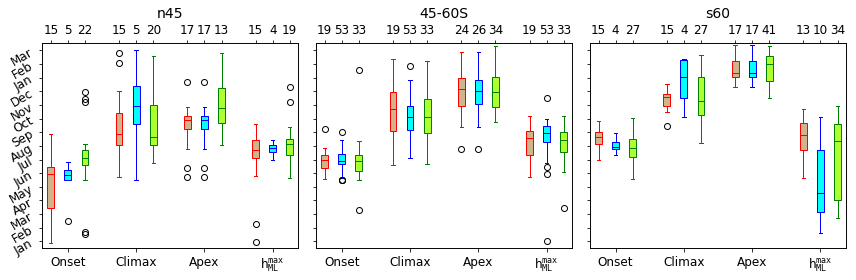

In [33]:
OnClApNa = [OnNa, ClNa, ApNa, MLNa]
OnClApMa = [OnMa, ClMa, ApMa, MLMa]
OnClApSa = [OnSa, ClSa, ApSa, MLSa]
OnClApNi = [OnNi, ClNi, ApNi, MLNi]
OnClApMi = [OnMi, ClMi, ApMi, MLMi]
OnClApSi = [OnSi, ClSi, ApSi, MLSi]
OnClApNp = [OnNp, ClNp, ApNp, MLNp]
OnClApMp = [OnMp, ClMp, ApMp, MLMp]
OnClApSp = [OnSp, ClSp, ApSp, MLSp]
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax4 = ax1.twiny()
ax5 = ax2.twiny()
ax6 = ax3.twiny()
fig.set_tight_layout(True)

draw_plot(ax1, OnClApNa, [1,5,9,13], 'red', 'tan')
draw_plot(ax1, OnClApNi, [2,6,10,14], 'blue', 'cyan')
draw_plot(ax1, OnClApNp, [3,7,11,15], 'green', 'greenyellow')
# setBoxColors(bp)
# ax1.boxplot(OnClApNp, vert=True, widths=.2, labels=['Onset','Climax','Apex'])
# ax.boxplot(Cls, vert=True, notch=True)
# ax.boxplot(Aps, vert=True, notch=True)
ax1.set_ylim(1,16)
ax1.set_yticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5])
ax1.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar'], 
                    fontsize=12, rotation=30)
# ax1.set_ylabel(r"Month", fontsize=13)
ax1.set_xlim([.5,15.5])
ax1.set_xticks([2,6,10,14])
ax1.set_xticklabels(['Onset','Climax','Apex',r"h$_{\tt ML}^{\tt max}$"], rotation=0, fontsize=12)
ax4.set_xlim([.5,15.5])
ax4.set_xticks([1,2,3,5,6,7,9,10,11,13,14,15])
ax4.set_xticklabels([len(OnNa),len(OnNi),len(OnNp),len(OnNa),len(OnNi),len(ClNp),
                    len(ApNa),len(ApNi),len(ApNp),len(MLNa),len(MLNi),len(MLNp)], rotation=0, fontsize=12)

draw_plot(ax2, OnClApMa, [1,5,9,13], 'red', 'tan')
draw_plot(ax2, OnClApMi, [2,6,10,14], 'blue', 'cyan')
draw_plot(ax2, OnClApMp, [3,7,11,15], 'green', 'greenyellow')
# ax.boxplot(Cls, vert=True, notch=True)
# ax.boxplot(Aps, vert=True, notch=True)
ax2.set_ylim(1,16)
ax2.set_yticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5])
ax2.set_yticklabels([], 
                    fontsize=12, rotation=30)
ax2.set_xlim([.5,15.5])
ax2.set_xticks([2,6,10,14])
ax2.set_xticklabels(['Onset','Climax','Apex',r"h$_{\tt ML}^{\tt max}$"], rotation=0, fontsize=12)
ax5.set_xlim([.5,15.5])
ax5.set_xticks([1,2,3,5,6,7,9,10,11,13,14,15])
ax5.set_xticklabels([len(OnMa),len(OnMi),len(OnMp),len(OnMa),len(OnMi),len(ClMp),
                    len(ApMa),len(ApMi),len(ApMp),len(MLMa),len(MLMi),len(MLMp)], rotation=0, fontsize=12)

draw_plot(ax3, OnClApSa, [1,5,9,13], 'red', 'tan')
draw_plot(ax3, OnClApSi, [2,6,10,14], 'blue', 'cyan')
draw_plot(ax3, OnClApSp, [3,7,11,15], 'green', 'greenyellow')
# ax.boxplot(Cls, vert=True, notch=True)
# ax.boxplot(Aps, vert=True, notch=True)
ax3.set_ylim(1,16)
ax3.set_yticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5])
ax3.set_yticklabels([], 
                    fontsize=12, rotation=30)
ax3.set_xlim([.5,15.5])
ax3.set_xticks([2,6,10,14])
ax3.set_xticklabels(['Onset','Climax','Apex',r"h$_{\tt ML}^{\tt max}$"], rotation=0, fontsize=12)
ax6.set_xlim([.5,15.5])
ax6.set_xticks([1,2,3,5,6,7,9,10,11,13,14,15])
ax6.set_xticklabels([len(OnSa),len(OnSi),len(OnSp),len(OnSa),len(OnSi),len(ClSp),
                    len(ApSa),len(ApSi),len(ApSp),len(MLSa),len(MLSi),len(MLSp)], rotation=0, fontsize=12)

ax1.set_title(r"n45", fontsize=14)
ax2.set_title(r"45-60S", fontsize=14)
ax3.set_title(r"s60", fontsize=14)